<u>Theme:</u>

* Calculate the value of Cuturi function and its gradient by using the robust sinkhorn iteration
* To confirm the feasiblity on Tensorflow

In [1]:
import numpy as np 
import matplotlib.pylab as plt
import tensorflow as tf

%matplotlib inline

In [2]:
sess = None

# 1. load MNIST data

In [3]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [4]:
N = 2**10
mut_dist_xy = np.mean(np.sum(np.abs(x_train[0:N-1,:,:] - x_train[1:N,:,:]), axis=(1,2)))

# 2. define Cuturi function based on the robust sinkhorn iteration:

In [5]:
def x_generator(_Z):
    
    f = lambda _XX, unit: tf.layers.dense(
            _XX, 
            units=unit, 
            activation=None, 
            kernel_initializer = tf.random_normal_initializer(stddev=tf.sqrt( 2/tf.cast(_XX.get_shape().as_list()[1], dtype=tf.float32))))
    _X = f(_Z, 500)
    _X = tf.nn.relu(_X)
    _X = f(_X, 500)
    _X = tf.nn.relu(_X)
    _X = f(_X, 28*28)
    _X = tf.sigmoid(_X)
    _X = tf.reshape(_X, shape=(-1, 28, 28))
    return _X

In [6]:
def robust_sinkhorn_iteration(_Mxy, _p, _q, _eps, _L, _tol):
    
    _q = tf.transpose(_q)

    _alpha = _p * 0
    _beta = _q * 0
    
    def terminate_cond(_itr, _alpha, _beta):
        _P = tf.exp(-(_Mxy-_alpha-_beta)/_eps -1)
        _qhat = tf.reduce_sum(_P, axis=0, keepdims=True)
        _err = tf.reduce_sum(tf.abs(_qhat - _q))
        return tf.logical_and(
            tf.less(_itr, _L),
            tf.greater(_err, _tol))
        
    def update_sinkhorn(_itr, _alpha, _beta):
        
        _delta_row = tf.reduce_min(_Mxy - _alpha, axis=0, keepdims=True)
        _beta = _eps + _eps * tf.log(_q) + _delta_row \
              - _eps * tf.log( tf.reduce_sum(tf.exp(-(_Mxy-_alpha-_delta_row)/_eps) , axis=0, keepdims=True)  )
        
        _delta_col = tf.reduce_min(_Mxy - _beta, axis=1, keepdims=True)
        _alpha = _eps + _eps * tf.log(_p) + _delta_col \
            - _eps * tf.log( tf.reduce_sum(tf.exp(-(_Mxy-_beta-_delta_col)/_eps) , axis = 1, keepdims=True)  )
        
        return _itr+1, _alpha, _beta
    
    _Nitr, _alpha, _beta = tf.while_loop(
        terminate_cond,
        update_sinkhorn,
        [0, _alpha, _beta])

    _dist = tf.reduce_sum(_p * _alpha) + tf.reduce_sum(_q * _beta) - _eps
    _P = tf.exp(-(_Mxy-_alpha-_beta)/_eps -1)
    return _P, _Nitr, _dist

In [7]:
def network_constructor(Ndim, Nz):
    
    _Z = tf.placeholder(shape=(None, Nz), dtype=tf.float32)
    _X = x_generator(_Z)
    _Y = tf.placeholder(shape=(None, *Ndim), dtype=tf.float32)
    
    _X2 = tf.expand_dims(_X, axis=1)
    _Y2 = tf.expand_dims(_Y, axis=0)
    
    _Mxy = tf.reduce_sum(tf.abs(_X2 - _Y2), axis=(2,3))
    
    _p = tf.placeholder(shape=(None, 1), dtype=tf.float32)
    _q = tf.placeholder(shape=(None, 1), dtype=tf.float32)
    
    _eps = tf.placeholder(shape=(), dtype=tf.float32)
    _L = tf.placeholder(shape=(), dtype=tf.int32)
    _tol = tf.placeholder(shape=(), dtype=tf.float32)
    
    _, _Nitr, _dist = robust_sinkhorn_iteration(_Mxy, _p, _q, _eps, _L, _tol)
    
    _lr = tf.placeholder(shape=(), dtype=tf.float32)
    
    _optimizer = tf.train.AdamOptimizer(_lr).minimize(_dist)
    
    return _Z, _X, _Y, _p, _q, _eps, _L, _tol, _dist, _lr, _optimizer, _Nitr

# 3. test run

Define y_generator:

In [8]:
Ndim = (28, 28)
def y_generator(Nb):
    idx = np.random.choice([*range(x_train.shape[0])], Nb)
    return x_train[idx,:,:]

Define z_generator:

In [9]:
Nz = 2
def z_generator(Nb):
    return np.random.rand(Nb, Nz)

Start session:

In [10]:
tf.reset_default_graph()
if sess is not None:
    sess.close()
sess = tf.InteractiveSession()

Construct a network:

In [11]:
_Z, _X, _Y, _p, _q, _eps, _L, _tol, _dist, _lr, _optimizer, _Nitr = \
    network_constructor(Ndim, Nz)

Run fitting:

In [12]:
sess.run(tf.global_variables_initializer())

Setup fit parameters:

In [13]:
eps = mut_dist_xy * 0.01
L = 2**10
tol = 1e-4
lr = 0.01
feed_dict = {_eps: eps, _L: L, _tol: tol, _lr: lr}

Setup minibatch parameters:

In [14]:
Nb = 2**5
p = np.ones((Nb, 1))/Nb
q = np.ones((Nb, 1))/Nb

In [15]:
Z = z_generator(Nb)
X = sess.run(_X, feed_dict={_Z: Z})

In [16]:
import sys
for k1 in range(x_train.shape[0] // Nb):
    Z = z_generator(Nb)
    Y = y_generator(Nb)
    X = sess.run(_X, feed_dict={_Z: Z})
    _, Nitr, loss = sess.run([_optimizer, _Nitr, _dist], feed_dict={**feed_dict, _Z: Z, _Y: Y, _p: p, _q: q})
    sys.stdout.write('\r itr = %3d loss = %5.2f Nitr = %4d [EOL]      ' % (k1+1, loss, Nitr))

 itr = 1875 loss = 67.44 Nitr = 1024 [EOL]      

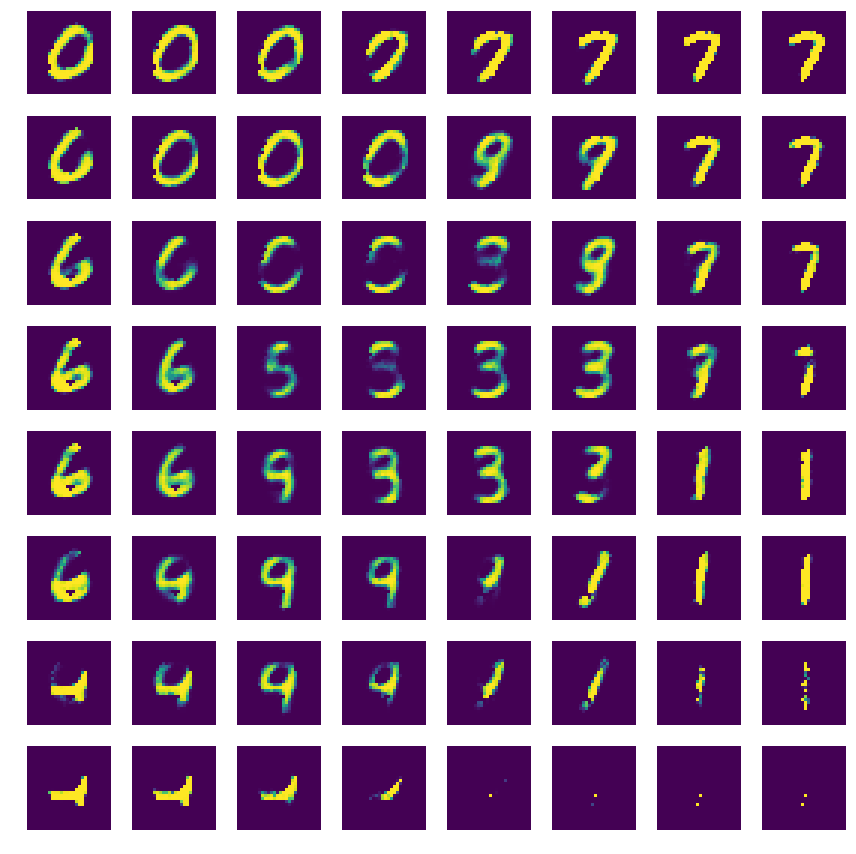

In [17]:
import itertools
nrow, ncol = (8, 8)

Z = np.array([*itertools.product(np.linspace(0,1,nrow),np.linspace(0,1,ncol))])

#Z = z_generator(nrow * ncol)
X = sess.run(_X, feed_dict={_Z: Z})
plt.figure(figsize=[30/2.57, 30.0/2.57])
plt.clf()
for k1 in range(nrow * ncol):
    ax = plt.subplot(nrow, ncol, k1+1)
    ax.imshow(X[k1,:,:])
    ax.set_axis_off()
plt.tight_layout(pad=0, h_pad=0, w_pad=0)

## easy check for sinkhorn iteration:

In [18]:
def robust_sinkhorn_iteration_numpy(Mxy, p, q, eps, L, tol=1e-8):
    
    q = q.T

    alpha = np.mean(Mxy, axis=1, keepdims=True) * 0
    beta = np.mean(Mxy, axis=0, keepdims=True) * 0
    
    for k1 in range(L):
              
        delta_row = np.min(Mxy - alpha, axis=0, keepdims=True)
        
        diff = np.min((Mxy-alpha-delta_row), axis=0)
        assert np.all(diff == 0), diff
        beta = eps + eps * np.log(q) + delta_row \
            - eps * np.log( np.sum(np.exp(-(Mxy-alpha-delta_row)/eps) , axis=0, keepdims=True)  )
        
        delta_col = np.min(Mxy - beta, axis=1, keepdims=True)
        
        diff = np.min((Mxy-beta-delta_col), axis=1)
        #import pdb; pdb.set_trace() 
        assert np.all(diff == 0), diff
        alpha = eps + eps * np.log(p) + delta_col \
            - eps * np.log( np.sum(np.exp(-(Mxy-beta-delta_col)/eps) , axis = 1, keepdims=True)  )
        
        P = np.exp(-(Mxy-alpha-beta)/eps -1)
        qhat = np.sum(P, axis=0, keepdims=True)
        err = np.sum(np.abs(qhat - q))
        
        if err < tol:
            break
    Nitr = k1 + 1
        
    return P, alpha, beta, Nitr

In [19]:
Mxy = np.sum(np.abs(X[:, np.newaxis, :, :] - Y[np.newaxis, :, :, :]), axis=(2,3))

In [20]:
P, alpha, beta , Nitr = robust_sinkhorn_iteration_numpy(Mxy, p, q, mut_dist_xy*0.01, L, tol = 1e-4)
print('Sinkhorn iteration = %2d' % Nitr)

ValueError: operands could not be broadcast together with shapes (32,1) (64,1) 

In [ ]:
np.sum(np.abs(np.sum(P, axis=0) - q.T))

In [ ]:
np.sum(np.abs(np.sum(P, axis=1) - p))

In [ ]:
plt.plot(alpha, beta.T, 'x')